# Chemical Equilibrium Transmission Spectra

This tutorial demonstrates how to access a chemical equilibrium grid and use it compute model transmission spectra.

## Equilibrium Chemistry Background

A gas is said to be in thermochemical equilibrium if all chemical reactions have reached a steady state. Under equilibrium chemistry, the molecular and atomic mixing ratios of a gas are determined only by the elemental abundances and the local temperature and pressure in each atmospheric layer. 

Any significant external factor that perturbs the composition of a gas layer on a faster timescale than equilibrium can be reached — such as vertical/horizontal mixing or photochemistry — is said to cause *disequilibrium* chemistry.

Nevertheless, the simplifying assumption of chemical equilibrium can be convenient for providing a first estimation of the chemical composition of hot giant exoplanets.

## Defining an Equilibrium Model 

For this tutorial, we will simulate a spectrum of the hot Jupiter WASP-62b.

First, we specify the properties of the star and planet.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J

#***** Define stellar properties *****#

R_s = 0.9*R_Sun   # Stellar radius (m)
T_s = 5400          # Stellar effective temperature (K)
Met_s = 0.01        # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.45        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-39 b'  # Planet name used for plots, output files etc.

R_p = 1.27*R_J     # Planetary radius (m)
M_p = 0.28*M_J       # Planetary mass (kg)
T_eq = 1116           # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

We can enable chemical equilibrium via the ``define_model`` function (see the [\"Generating Transmission Spectra\"](transmission_basic.html) tutorial) by specifying ``X_profile = 'chem_eq'`` (i.e. the mixing ratio vertical profiles will follow equilibrium chemistry). 

There are two ways to define a chemical equilibrium model in POSEIDON:

1. To use the full set of chemical species included in the chemical equilibrium grid, set ``param_species = ['all']``. 
2. To use a *specific subset* of the equilibrium grid (e.g., to speed up calculations or explore how removing a molecule changes the results), set ``param_species`` to the list of chemical species you want included in the model.

We'll now create both types of chemical equilibrium model.

In [2]:
from POSEIDON.core import define_model
import numpy as np

#***** Define models *****#

model_name_1 = 'eq_chemistry_full'   
model_name_2 = 'eq_chemistry_subset'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere

param_species_full = ['all']
param_species_subset = ['H','H2O', 'CH4', 'CO', 'CO2']

model_subset = define_model(model_name_2, bulk_species, param_species_subset, 
                            X_profile = 'chem_diseq',
                            diseq_grid_name = "VULCAN_Grid1.1")

In [3]:
print("Free parameters : " + str(model_subset['param_names']))

Free parameters : ['R_p_ref' 'log_kappa_IR' 'T_equ' 'C_O' 'log_met']


In [4]:
print(model_subset['PT_param_names'])

[]


## Load Chemical Equilibrium Grid

We now need to load a specific equilibrium grid. Here we will use a grid from [fastchem](https://github.com/exoclime/FastChem).

In [5]:
from POSEIDON.chemistry import load_vulcan_chemistry_grid

# Load the subset chemical equilibrium grid
chemistry_grid_subset = load_vulcan_chemistry_grid(param_species_subset, grid = "VULCAN_Grid1.1")

Reading in database for VULCAN model...


In [6]:
print(chemistry_grid_subset.keys())

dict_keys(['grid', 'log_X_grid', 'pressures', 'temp_profiles', 'conv_flags', 'species', 'property_names', 'grid_lists'])


## Create an Atmosphere with Equilibrium Abundances

In [7]:
from POSEIDON.core import make_atmosphere
from POSEIDON.visuals import plot_chem

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 0.1 ubar
P_max = 10       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

T_eq = 700
log_kappa_IR = -3.0

# Specify carbon to oxygen ratio and metallicity for atmosphere
C_to_O = 0.55    # C/O
log_Met = 0.0    # log_10 (metallicity)

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([])              # T (K)
X_params = np.array([log_kappa_IR, T_eq, C_to_O, log_Met])    # The parameters are just C/O and log(Met) for an equilibrium model

# Generate two atmospheres: one with the full equilibrium grid and one with the subset
atmosphere_subset = make_atmosphere(planet, model_subset, P, P_ref, R_p_ref, PT_params, 
                                    X_params, chemistry_grid = chemistry_grid_subset)

Let's plot the mixing ratios of several gases.

Text(0.5, 0.94, 'log Met =0.0, C/O = 0.55')

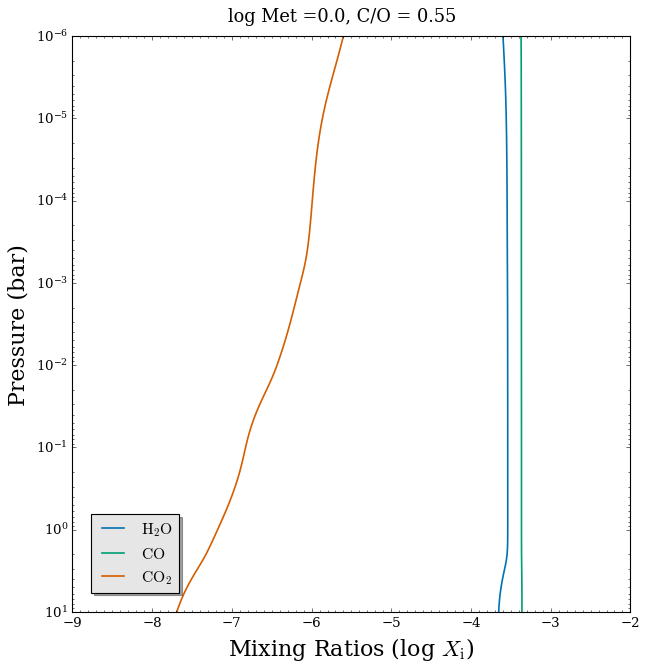

In [8]:
# Define a colour blind friendly colour list
CB_colour_cycle = ['#0072B2', '#009E73', '#D55E00']

# Plot mixing ratio profiles
fig_chem = plot_chem(planet, model_subset, atmosphere_subset, colour_list = CB_colour_cycle,
                     plot_species = ['H2O', 'CO', 'CO2'],   # Just 4 of the 28 included chemical species
                     legend_location = 'lower left')

# Add plot title
fig_chem.suptitle('log Met =' + str(log_Met) + ', C/O = ' + str(C_to_O), fontsize = 16, y = 0.94)

### Load Opacities

In [9]:
from POSEIDON.core import wl_grid_constant_R, read_opacities

#***** Wavelength grid *****#
 
wl_min = 0.5       # Minimum wavelength (um)
wl_max = 13       # Maximum wavelength (um)
R = 5000          # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 100     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 10000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the sampled opacities for both models (the subset will be faster!)
opac_subset = read_opacities(model_subset, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-H done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
Opacity pre-interpolation complete.


As you can see, one disadvantage of using the full equilibrium database is that more time and RAM is required to handle all the opacities. If you know *a priori* that a given chemical species is not important (e.g. its absorption features lie outside the wavelength range you are modelling), consider using a subset model excluding the non-important chemical species.

### Compute Transmission Spectrum

Now we can create transmission spectra for both the full equilibrium model and the subset model.

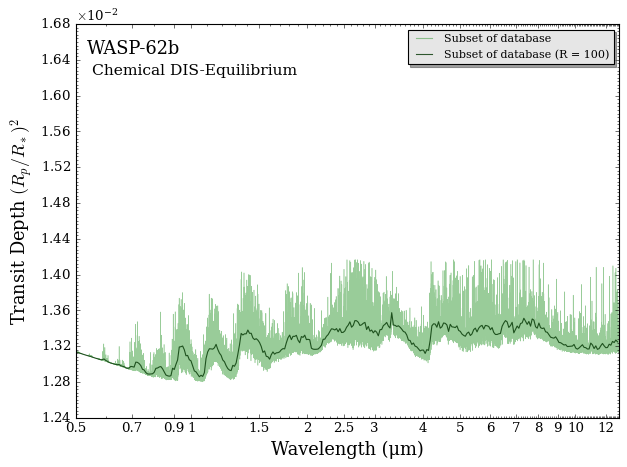

In [10]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectrum_subset = compute_spectrum(planet, star, model_subset, atmosphere_subset, 
                                   opac_subset, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = []
spectra = plot_collection(spectrum_subset, wl, collection = spectra)

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 100, 
                   y_min = 1.24e-2, y_max = 1.68e-2,
                   spectra_labels = ['Subset of database'],
                   plt_label = 'Chemical DIS-Equilibrium')

Figuring out grid spacing 

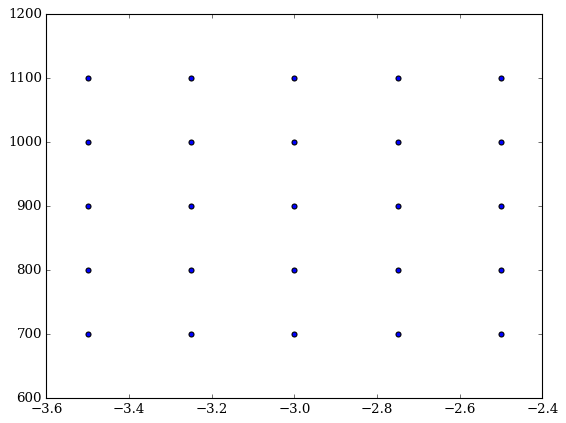

In [17]:
kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]


points_array = []

for n in range(len(kappa_IR)):
    for m in range(len(Teq)):
        points_array.append((kappa_IR[n],Teq[m]))

x_coords, y_coords = zip(*points_array)

import matplotlib.pyplot as plt 

plt.scatter(x_coords,y_coords)

16


Text(0.5, 0, 'log Kappa ir ')

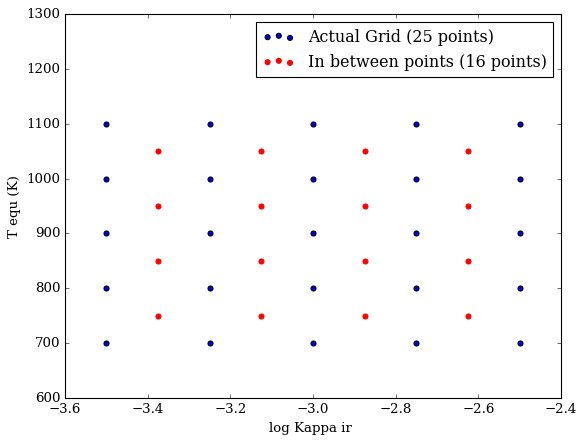

In [50]:
kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]


I,J = np.meshgrid(kappa_IR,Teq,indexing='ij')   

plt.scatter(I,J, label = 'Actual Grid (25 points)')

I_halfway = (I[1:,1:]+I[:-1,:-1])/2
J_halfway = (J[1:,1:]+J[:-1,:-1])/2

print(len(I_halfway)*len(J_halfway))

plt.scatter(I_halfway, J_halfway, color = 'red', label = 'In between points (16 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

25
16


Text(0.5, 0, 'log Kappa ir ')

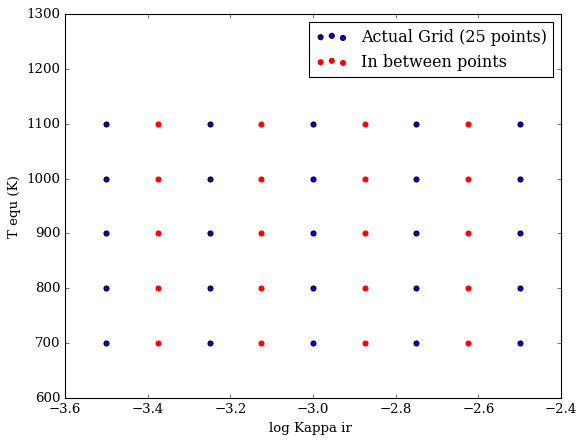

In [48]:
kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]


I,J = np.meshgrid(kappa_IR,Teq,indexing='ij')  

print(len(I)*len(J))

plt.scatter(I,J, label = 'Actual Grid (25 points)')

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2

print(len(I_halfway)*len(J_halfway))

plt.scatter(I_halfway, J_halfway, color = 'red', label = 'In between points (16 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

In [66]:
print((J.T[1:] + J.T[:-1])/2)

[[ 750.  750.  750.  750.  750.]
 [ 850.  850.  850.  850.  850.]
 [ 950.  950.  950.  950.  950.]
 [1050. 1050. 1050. 1050. 1050.]]


Text(0.5, 0, 'log Kappa ir ')

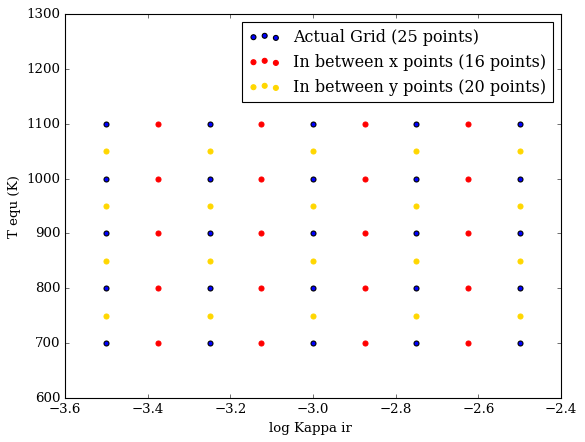

In [77]:
kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]


I,J = np.meshgrid(kappa_IR,Teq,indexing='ij')  
X,Y = np.meshgrid(kappa_IR,Teq)

plt.scatter(I,J, label = 'Actual Grid (25 points)')

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2

plt.scatter(I_halfway, J_halfway, color = 'red', label = 'In between x points (16 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

I_halfway = ((I.T[1:]+I.T[:-1])/2).T
J_halfway = ((J.T[1:]+J.T[:-1])/2).T

plt.scatter(I_halfway, J_halfway, color = 'gold', label = 'In between y points (20 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

3d

Text(0.5, 0, 'log Kappa ir ')

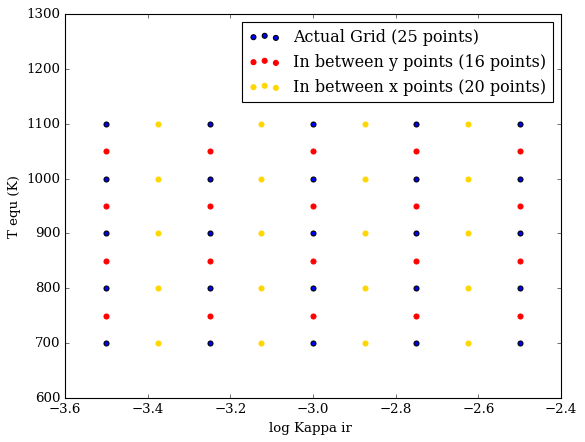

In [100]:
kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]


I,J = np.meshgrid(kappa_IR,Teq)  

plt.scatter(I,J, label = 'Actual Grid (25 points)')

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2

plt.scatter(I_halfway, J_halfway, color = 'red', label = 'In between y points (16 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

I_halfway = ((I.T[1:]+I.T[:-1])/2).T
J_halfway = ((J.T[1:]+J.T[:-1])/2).T

plt.scatter(I_halfway, J_halfway, color = 'gold', label = 'In between x points (20 points)')
plt.legend()
plt.ylim(600,1300)
plt.ylabel('T equ (K)')
plt.xlabel('log Kappa ir ')

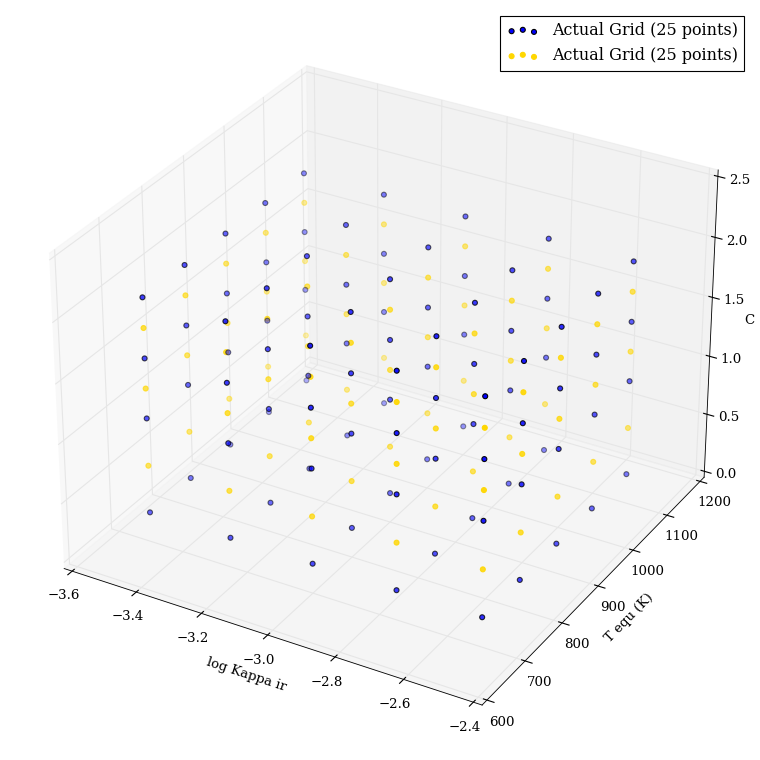

In [116]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')

kappa_IR = [-3.5,-3.25,-3.0,-2.75,-2.50]
Teq = [700,800,900,1000,1100]
C_O = [0.2, 1, 1.5, 2]

I,J,K = np.meshgrid(kappa_IR,Teq,C_O)  
ax.scatter(I,J,K, label = 'Actual Grid (25 points)')

#I_halfway = (I[1:]+I[:-1])/2
#J_halfway = (J[1:]+J[:-1])/2
#K_halfway = (K[1:]+K[:-1])/2
#
#ax.scatter(I_halfway,J_halfway,K_halfway,color = 'red', label = 'Actual Grid (25 points)')


# This builds halfway between k, so it copies the I and J grid just in between k points
I_halfway_2 = ((I.T[1:]+I.T[:-1])/2).T
J_halfway_2 = ((J.T[1:]+J.T[:-1])/2).T
K_halfway_2 = ((K.T[1:]+K.T[:-1])/2).T

ax.scatter(I_halfway_2,J_halfway_2,K_halfway_2,color = 'gold', label = 'Actual Grid (25 points)')

ax.legend()
ax.set_ylabel('T equ (K)')
ax.set_xlabel('log Kappa ir ')
ax.set_zlabel('C O')
plt.show()


In [130]:
print((np.flipud(I[1:])))

[[[-3.5  -3.5  -3.5  -3.5 ]
  [-3.25 -3.25 -3.25 -3.25]
  [-3.   -3.   -3.   -3.  ]
  [-2.75 -2.75 -2.75 -2.75]
  [-2.5  -2.5  -2.5  -2.5 ]]

 [[-3.5  -3.5  -3.5  -3.5 ]
  [-3.25 -3.25 -3.25 -3.25]
  [-3.   -3.   -3.   -3.  ]
  [-2.75 -2.75 -2.75 -2.75]
  [-2.5  -2.5  -2.5  -2.5 ]]

 [[-3.5  -3.5  -3.5  -3.5 ]
  [-3.25 -3.25 -3.25 -3.25]
  [-3.   -3.   -3.   -3.  ]
  [-2.75 -2.75 -2.75 -2.75]
  [-2.5  -2.5  -2.5  -2.5 ]]

 [[-3.5  -3.5  -3.5  -3.5 ]
  [-3.25 -3.25 -3.25 -3.25]
  [-3.   -3.   -3.   -3.  ]
  [-2.75 -2.75 -2.75 -2.75]
  [-2.5  -2.5  -2.5  -2.5 ]]]


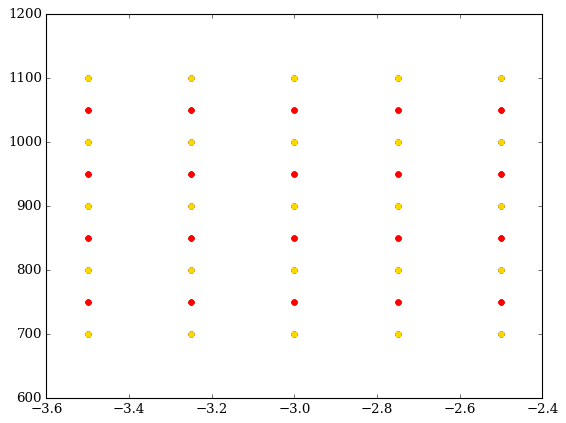

In [109]:
I,J,K = np.meshgrid(kappa_IR,Teq,C_O)  

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2
K_halfway = (K[1:]+K[:-1])/2

I_halfway_2 = ((I.T[1:]+I.T[:-1])/2).T
J_halfway_2 = ((J.T[1:]+J.T[:-1])/2).T
K_halfway_2 = ((K.T[1:]+K.T[:-1])/2).T

plt.scatter(I,J, color = 'blue')
plt.scatter(I_halfway,J_halfway, color = 'red')
plt.scatter(I_halfway_2,J_halfway_2, color = 'gold')

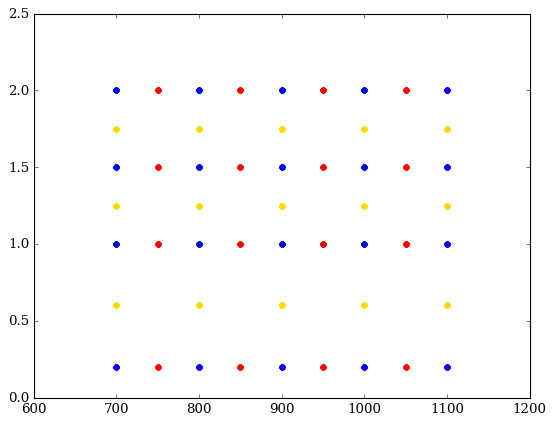

In [110]:
I,J,K = np.meshgrid(kappa_IR,Teq,C_O)  

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2
K_halfway = (K[1:]+K[:-1])/2

I_halfway_2 = ((I.T[1:]+I.T[:-1])/2).T
J_halfway_2 = ((J.T[1:]+J.T[:-1])/2).T
K_halfway_2 = ((K.T[1:]+K.T[:-1])/2).T

plt.scatter(J,K, color = 'blue')
plt.scatter(J_halfway,K_halfway, color = 'red')
plt.scatter(J_halfway_2,K_halfway_2, color = 'gold')

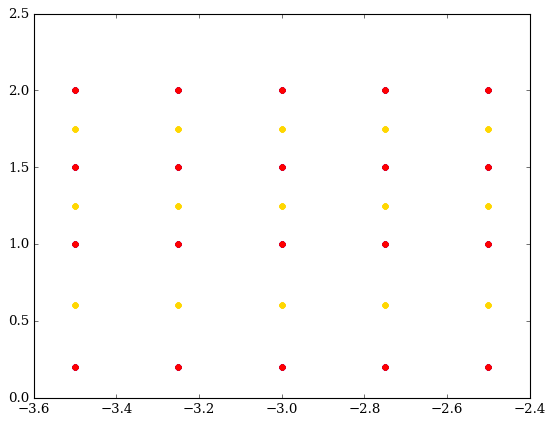

In [111]:
I,J,K = np.meshgrid(kappa_IR,Teq,C_O)  

I_halfway = (I[1:]+I[:-1])/2
J_halfway = (J[1:]+J[:-1])/2
K_halfway = (K[1:]+K[:-1])/2

I_halfway_2 = ((I.T[1:]+I.T[:-1])/2).T
J_halfway_2 = ((J.T[1:]+J.T[:-1])/2).T
K_halfway_2 = ((K.T[1:]+K.T[:-1])/2).T

plt.scatter(I,K, color = 'blue')
plt.scatter(I_halfway,K_halfway, color = 'red')
plt.scatter(I_halfway_2,K_halfway_2, color = 'gold')